PROCESO EDA PARA MODELO DE RECOMENDACION

In [1]:
import pandas as pd

from wordcloud import WordCloud 
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
movies = pd.read_parquet('../PI01/movies_con_etl.parquet')

In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45464 entries, 0 to 45338
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                45376 non-null  float64       
 1   genres                45464 non-null  object        
 2   id_pelicula           45376 non-null  object        
 3   original_language     45365 non-null  object        
 4   overview              44435 non-null  object        
 5   popularity            45376 non-null  float64       
 6   production_companies  45464 non-null  object        
 7   production_countries  45464 non-null  object        
 8   release_date          45376 non-null  datetime64[ns]
 9   revenue               45376 non-null  float64       
 10  runtime               45130 non-null  float64       
 11  spoken_languages      45464 non-null  object        
 12  status                45296 non-null  object        
 13  tagline              

PARA EL 'EDA' DEL MODELO, VAMOS A UTILIZAR EL DATASET 'MOVIES' QUE SE REALIZO EN EL PROCESO DE ETL_1.

PARA EL SISTEMA DE RECOMENDACION, SE DECIDE UTILIZAR EL MODELO DE SIMILITUD DEL COSENO. ESTE MODELO REQUIERE QUE LE PROPORCIONEMOS DATOS QUE NOS PERMITAN COMPARAR VECTORES (GENERADOS CON TF-IDF VECTORIZER) ENTRE LAS DIFERENTES PELICULAS. LA RELACION ESTA DADA ENTRE '0' Y '1', SIENDO '1' UNA SIMILITUD EXACTA Y '0' UNA SIMILITUD NULA ENTRE VECTORES.

PARA PODER IMPLEMENTAR ESTE MODELO, SE TIENEN EN CUENTA LOS SIGUIENTES CRITERIOS:

1- EL VALOR A VECTORIZAR SERAN LOS QUE CONTIENE LA COLUMNA 'OVERVIEW', YA QUE ESTA POSEE INFORMACION DETALLADA DE CADA PELICULA.
    
2- POR SER RENDER UNA APLICACION QUE NOS LIMITA LA CAPACIDAD DE COMPUTO, SE REDUCE EL DATASET DE CONSULTA A SOLO 4000 FILAS.

In [4]:
#Limpiamos el dataset de valores no nulos segun los datos de 'overview'

movies_modelo = movies.dropna(axis=0,subset='overview')

In [5]:
movies_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44435 entries, 0 to 45465
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                44435 non-null  float64       
 1   genres                44435 non-null  object        
 2   id_pelicula           44435 non-null  object        
 3   original_language     44425 non-null  object        
 4   overview              44435 non-null  object        
 5   popularity            44435 non-null  float64       
 6   production_companies  44435 non-null  object        
 7   production_countries  44435 non-null  object        
 8   release_date          44435 non-null  datetime64[ns]
 9   revenue               44435 non-null  float64       
 10  runtime               44435 non-null  float64       
 11  spoken_languages      44435 non-null  object        
 12  status                44371 non-null  object        
 13  tagline              

In [6]:
movies_modelo['id_pelicula'].describe()

count      44435
unique     44405
top       141971
freq           3
Name: id_pelicula, dtype: object

In [7]:
#Eliminamos los valores duplicados de 'id_pelicula'

movies_modelo = movies_modelo.drop_duplicates(subset=['id_pelicula'])

In [8]:
# Revisamos el formato de los datos de 'overview'.

movies_modelo['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [ ]:
# Hacemos una nube de palabras para tener un panorama de que tenemos como datos (posibles distintos idiomas, 
# formato que no sean cadena, etc.)

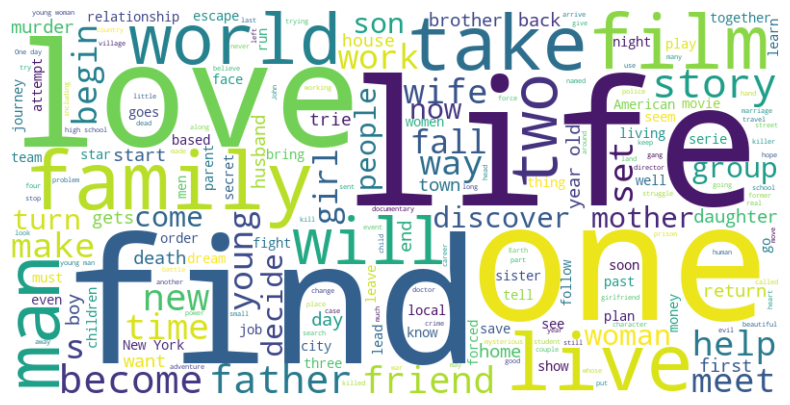

In [9]:
# Combinar todos los textos en una sola cadena
nube_de_palabras = " ".join(texto for texto in movies_modelo['overview'])

# Crear una nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(nube_de_palabras)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
movies_modelo['overview'].describe()

count                  44405
unique                 44232
top       No overview found.
freq                     133
Name: overview, dtype: object

In [ ]:
# Vemos que hay valores de overview duplicados, exploramos cuales son para eliminarlos ya que podrian traer 
# inconvenientes para el modelo de recomndacion.

In [11]:
duplicados = movies_modelo[movies_modelo.duplicated(subset=['overview'], keep=False)]

In [12]:
duplicados[['overview','title']]

,overview,title
104,No overview found.,Nobody Loves Me
800,No overview found.,Kaspar Hauser
972,No overview found.,L'associé
1613,No overview found.,Alien Escape
2028,Wilbur the pig is scared of the end of the sea...,Charlotte's Web
...,...,...
45272,No overview found.,Hemo The Magnificent
45292,No overview found.,Hydrozagadka
45386,An abstract animation from Walter Ruttmann.,Opus II
45387,An abstract animation from Walter Ruttmann.,Opus III


In [ ]:
# Eliminamos las columnas que no tienen overview.

In [13]:
movies_modelo[movies_modelo['overview'] == 'No overview found.']

,budget,genres,id_pelicula,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,release_year,return,colection_name
104,0.0,"[Drama, Comedy, Family]",11907,de,No overview found.,1.015068,[],[Germany],1994-11-07,0.0,104.0,[Deutsch],Released,None,Nobody Loves Me,5.1,5.0,1994.0,0.0,None
800,0.0,"[Drama, Foreign]",12632,de,No overview found.,0.000578,[],"[Austria, Germany, Sweden]",1993-09-11,0.0,139.0,[Deutsch],Released,None,Kaspar Hauser,6.3,4.0,1993.0,0.0,None
972,0.0,[Comedy],25739,en,No overview found.,0.000308,[],[],1979-08-22,0.0,94.0,[],Released,None,L'associé,6.0,3.0,1979.0,0.0,None
1613,1000000.0,"[Horror, Science Fiction]",29938,en,No overview found.,0.106499,[],[United States of America],1996-01-01,0.0,85.0,[English],Released,Run Baby Run!,Alien Escape,4.5,2.0,1996.0,0.0,None
2230,0.0,"[Comedy, Thriller]",8336,en,No overview found.,0.942562,[],[United States of America],1998-08-02,0.0,98.0,[English],Released,None,The Naked Man,6.0,3.0,1998.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44607,0.0,[],144430,en,No overview found.,0.070817,[],[],1978-01-01,0.0,17.0,[],Released,None,Ded Moroz i seriy volk,4.5,2.0,1978.0,0.0,None
45251,0.0,[Comedy],28469,de,No overview found.,0.192235,[Österreichischer Rundfunk (ORF)],[Austria],1961-11-15,0.0,60.0,[Deutsch],Released,None,Der Herr Karl,10.0,1.0,1961.0,0.0,None
45272,0.0,"[Animation, Family]",89606,en,No overview found.,0.054726,[],[],1957-03-20,0.0,60.0,[English],Released,None,Hemo The Magnificent,7.0,1.0,1957.0,0.0,None
45292,0.0,"[Crime, Comedy]",31856,en,No overview found.,0.106280,[],[Poland],1971-04-30,0.0,70.0,[Polski],Released,None,Hydrozagadka,5.3,3.0,1971.0,0.0,None


In [14]:
indices_a_eliminar = movies_modelo[movies_modelo['overview'] == 'No overview found.'].index

In [15]:
movies_modelo = movies_modelo.drop(indices_a_eliminar)

In [16]:
movies_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44272 entries, 0 to 45465
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                44272 non-null  float64       
 1   genres                44272 non-null  object        
 2   id_pelicula           44272 non-null  object        
 3   original_language     44262 non-null  object        
 4   overview              44272 non-null  object        
 5   popularity            44272 non-null  float64       
 6   production_companies  44272 non-null  object        
 7   production_countries  44272 non-null  object        
 8   release_date          44272 non-null  datetime64[ns]
 9   revenue               44272 non-null  float64       
 10  runtime               44272 non-null  float64       
 11  spoken_languages      44272 non-null  object        
 12  status                44208 non-null  object        
 13  tagline              

In [29]:
# Recortamos el modelo a solo la informacion que nos va a ser util para el sistema de recomendacion.

movies_modelo_recortado = movies_modelo[['id_pelicula', 'title', 'overview', 'popularity', 'vote_count']]

In [30]:
# Reseteamos los indices, ya que estos nos van a ayudar a relacionar la matriz de similitud con los id de las peliculas.

movies_modelo_recortado.reset_index(drop=True, inplace=True)

In [31]:
movies_modelo_recortado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44272 entries, 0 to 44271
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_pelicula  44272 non-null  object 
 1   title        44272 non-null  object 
 2   overview     44272 non-null  object 
 3   popularity   44272 non-null  float64
 4   vote_count   44272 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.7+ MB


In [32]:
movies_modelo_recortado.sort_values(by='popularity', ascending=False).head()

,id_pelicula,title,overview,popularity,vote_count
30221,211672,Minions,"Minions Stuart, Kevin and Bob are recruited by...",547.488298,4729.0
32747,297762,Wonder Woman,An Amazon princess comes to the world of Man t...,294.337037,5025.0
41198,321612,Beauty and the Beast,A live-action adaptation of Disney's version o...,287.253654,5530.0
42548,339403,Baby Driver,After being coerced into working for a crime b...,228.032744,2083.0
24166,177572,Big Hero 6,The special bond that develops between plus-si...,213.849907,6289.0


HACEMOS LIMPIEZA PROFUNDA PARA DISMINUIR EL DATASET Y PODER LLEVARLO A RENDER

In [33]:
movies_modelo_recortado['overview'].describe()

count           44272
unique          44231
top       No Overview
freq                7
Name: overview, dtype: object

In [34]:
duplicados = movies_modelo_recortado[movies_modelo_recortado.duplicated(subset=['overview'], keep=False)]
print(duplicados[['overview','title']])

                                                overview  \
2005   Wilbur the pig is scared of the end of the sea...   
2351   With friends like these, who needs enemies? Th...   
2690   Poor but happy, young Nello and his grandfathe...   
2934   Director Michael Apted revisits the same group...   
3212                                    No overview yet.   
...                                                  ...   
42921  A wooden boy Buratino tries to find his place ...   
42970                       No movie overview available.   
43377  Karol has everything. He has three mistresses ...   
44197        An abstract animation from Walter Ruttmann.   
44198        An abstract animation from Walter Ruttmann.   

                            title  
2005              Charlotte's Web  
2351                      Payback  
2690            A Dog Of Flanders  
2934                        42 Up  
3212               Condo Painting  
...                           ...  
42921  The Adventures of Bu

In [ ]:
# Sabemos que tenemos que reducir lo mas posible el dataset por cuestiones de rendimiento de Render, 
# por lo que hacemos un analisis de cuales peliculas/filas podemos eliminar.

# Un criterio puede ser eliminar las peliculas que no son populares. Para esto vemos como se distribuye el puntaje de 
# 'popularity' para todo nuestro dataset y elegir un valor de corte.

# Tambien visualizar si existen valores atipicos, ya que pueden alterar la decision.

In [35]:
movies_modelo_recortado['popularity'].describe()

count    44272.000000
mean         2.982482
std          6.070807
min          0.000000
25%          0.407306
50%          1.166526
75%          3.826900
max        547.488298
Name: popularity, dtype: float64

In [ ]:
# Vemos que hay valores de 0, estos no nos sirven. Tambien podemos ver que se 
# usen solo los que tienen cierta cantidad de votos.

In [ ]:
# Graficamos estos valores.

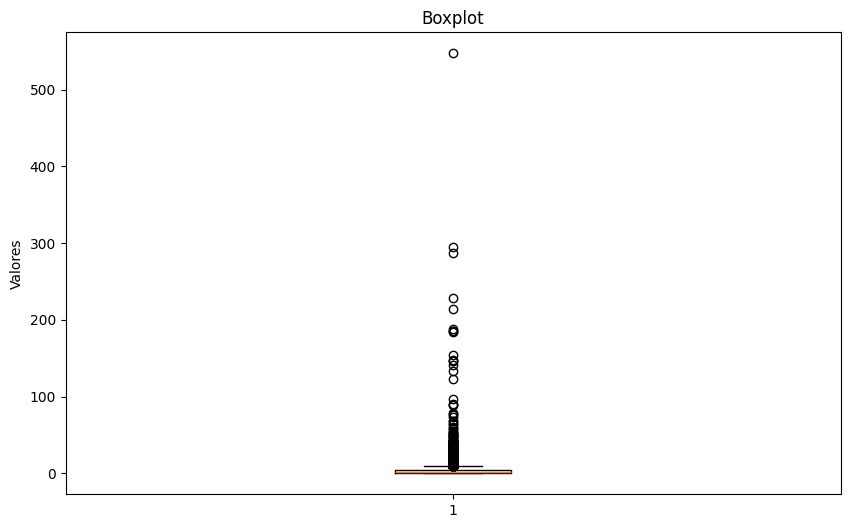

In [36]:
# Boxplot popularity

plt.figure(figsize=(10, 6))
plt.boxplot(movies_modelo_recortado['popularity'])
plt.title('Boxplot')
plt.ylabel('Valores')
plt.show()

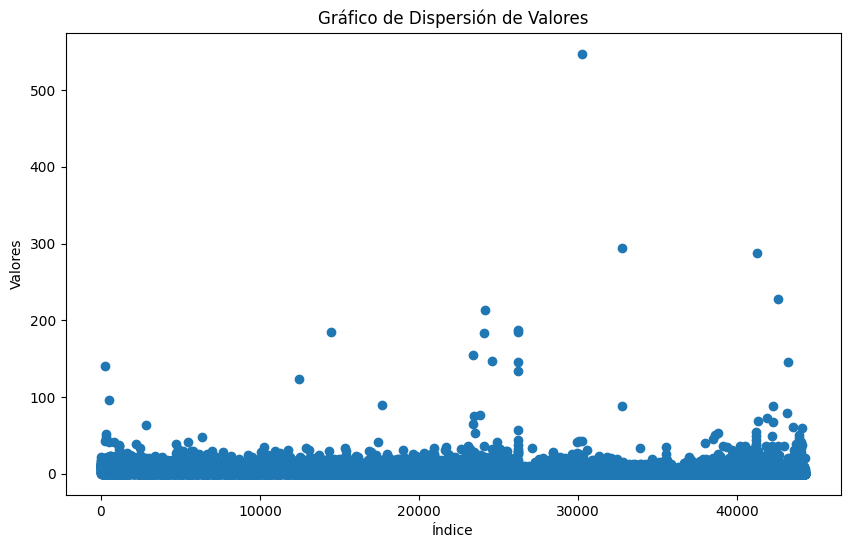

In [37]:
# Gráfico de dispersión popularity

plt.figure(figsize=(10, 6))
plt.scatter(movies_modelo_recortado.index, movies_modelo_recortado['popularity'])
plt.title('Gráfico de Dispersión de Valores')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.show()


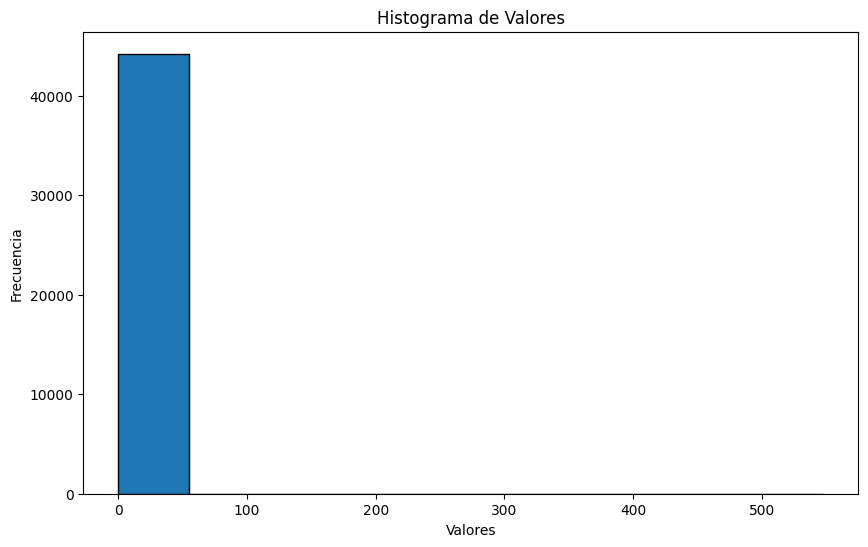

In [38]:
# Histograma popularity

plt.figure(figsize=(10, 6))
plt.hist(movies_modelo_recortado['popularity'], bins=10, edgecolor='black')
plt.title('Histograma de Valores')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
# Vemos que existe una distribucion muy despareja. Veamos cuales son los que tienen mayor puntaje de popularidad.

In [39]:
movies_modelo_recortado[['title','vote_count','popularity']].sort_values(by='popularity', ascending=False).head(10)

,title,vote_count,popularity
30221,Minions,4729.0,547.488298
32747,Wonder Woman,5025.0,294.337037
41198,Beauty and the Beast,5530.0,287.253654
42548,Baby Driver,2083.0,228.032744
24166,Big Hero 6,6289.0,213.849907
26216,Deadpool,11444.0,187.860492
26218,Guardians of the Galaxy Vol. 2,4858.0,185.330992
14467,Avatar,12114.0,185.070892
24062,John Wick,5499.0,183.870374
23404,Gone Girl,6023.0,154.801009


In [ ]:
# Con estos datos no podemos saber si los valores de 'popularity' son atipicos debido a errores, por lo que el 
# recorte lo podemos hacer de forma mas seguro por la cantidad de votos que tienen las peliculas.

In [40]:
movies_modelo_recortado['vote_count'].describe()

count    44272.000000
mean       112.588544
std        497.562387
min          0.000000
25%          3.000000
50%         10.000000
75%         35.000000
max      14075.000000
Name: vote_count, dtype: float64

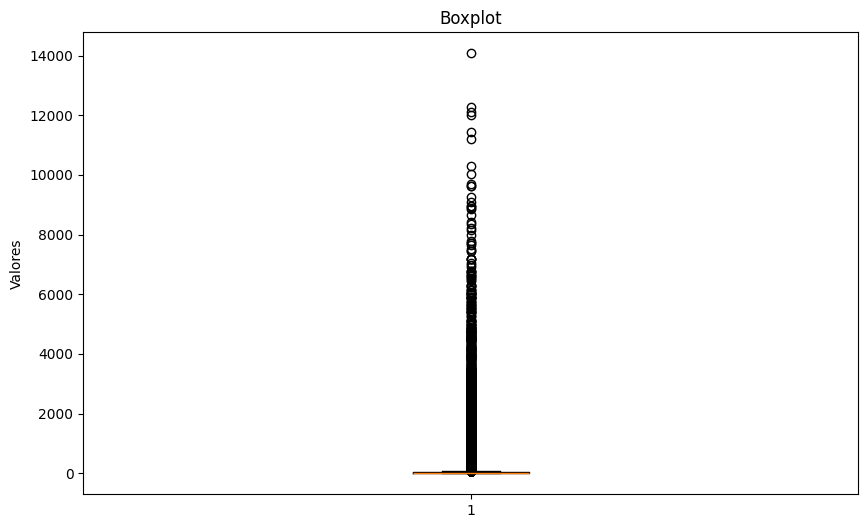

In [41]:
# Boxplot vote_count

plt.figure(figsize=(10, 6))
plt.boxplot(movies_modelo_recortado['vote_count'])
plt.title('Boxplot')
plt.ylabel('Valores')
plt.show()

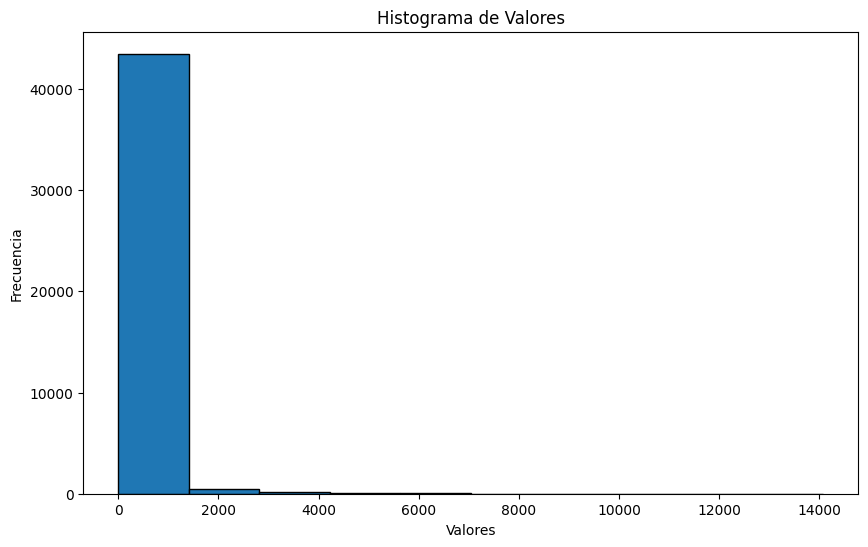

In [42]:
# Histograma vote_count

plt.figure(figsize=(10, 6))
plt.hist(movies_modelo_recortado['vote_count'], bins=10, edgecolor='black')
plt.title('Histograma de Valores')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# En el dataset vamos a dejar solo las peliculas que tienen mas de el promedio de votos que es 112 para 
# garantizarnos que el valor de popularidad sea representativo, y luego recortamos 
# por los primeros 4000 en base a su popularidad.

In [44]:
movies_modelo_recortado = movies_modelo[movies_modelo['vote_count'] >= 112]

In [45]:
movies_modelo_recortado['popularity'].describe()

count    5622.000000
mean       10.969048
std        13.273807
min         0.010902
25%         6.962500
50%         9.160699
75%        12.135392
max       547.488298
Name: popularity, dtype: float64

In [46]:
movies_modelo_recortado = movies_modelo_recortado.sort_values(by='popularity', ascending=False).head(4000)

# Dejamos solo las columnas que nos interesan para poder hacer el modelo de recomendacion.
movies_modelo_recortado = movies_modelo_recortado[['id_pelicula', 'title', 'overview']]

# Hacemos el reset de los indices ya que estos nos van a ayudar luego con los datos de similitud de coseno.
movies_modelo_recortado.reset_index(drop=True, inplace=True)

In [47]:
movies_modelo_recortado.head()

,id_pelicula,title,overview
0,211672,Minions,"Minions Stuart, Kevin and Bob are recruited by..."
1,297762,Wonder Woman,An Amazon princess comes to the world of Man t...
2,321612,Beauty and the Beast,A live-action adaptation of Disney's version o...
3,339403,Baby Driver,After being coerced into working for a crime b...
4,177572,Big Hero 6,The special bond that develops between plus-si...


In [ ]:
movies_modelo_recortado.to_parquet('movies_modelo_recortado.parquet')

CREACION DEL MODELO DE SIMILITUD DEL COSENO. 

UNA VEZ QUE SE TIENEN TODOS LOS DATOS LIMPIOS, PROCEDEMOS A GENERAR LA VECTORIZACION DE LOS VALORES DE LA COLUMNA 'OVERVIEW' MEDIANTE TF-IDFVECTORIZER. PARA HACERLO UN POCO MAS EFICIENTE A ESTE PROCESO, AGREGAMOS EL PARAMETRO 'STOP_WORDS' QUE NOS PERMITE IGNORAR PALABRAS REPETITIVAS EN EL IDIOMA QUE SE ENCUENTRAN LOS DATOS.

LUEGO DE GENERADA LA MATRIZ TF-IDF, PODEMOS REALIZAR EL CALCULO DE LA SIMILITUD DEL COSENO. ESTE PROCESO LO QUE HACE ES COMPARAR EL ANGULO DE CADA VECTOR. ESTA COMPARACION ESTA COMPRENDIDA ENTRE 0 Y 1. DE ESTA FORMA, PODEMOS SABER QUE LOS 5 VALORES MAS CERCANOS PARA UNA PELICULA DADA, SON LOS QUE TIENEN MEJOR RELACION Y POR ENDE, DEBERIA RECOMENDAR NUESTRO MODELO.

In [48]:
# Vamos a vectorizar la columna 'overview' del dataset para utilizar eso luego en la similitud del coseno.

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
#tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_modelo_recortado['overview'])

In [49]:
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 101574 stored elements and shape (4000, 18461)>

In [50]:
# Hacemos el calculo de la similitud del coseno para todas las peliculas. Con estos valores luego vamos a poder encontrar 
# las peliculas mas similares entre si (valores mas proximos a 1).

similitud_coseno = cosine_similarity(tfidf_matrix)

In [182]:
# Hacemos un dataframe de esos valores encontrados por similitud de coseno para guardarlo y cargarlo luego en Render.

similitud_coseno_df = pd.DataFrame(similitud_coseno)

In [ ]:
similitud_coseno_df.to_parquet('similitud_coseno_df.parquet')

CREACION DE LA FUNCION. 

PROBAMOS LOCALMENTE NUESTRO MODELO.

In [ ]:
# Para un manejo mas sencillo de los valores, cargamos los datos como un array. 

similitud_coseno_arr = similitud_coseno_df.values

In [173]:
movies_modelo_recortado[movies_modelo_recortado['title'] == 'Toy Story']

,id_pelicula,title,overview
196,862,Toy Story,"Led by Woody, Andy's toys live happily in his ..."


In [181]:
indice = 196

# Aca podemos ver los valores de la similitud de coseno, para la pelicula elegida.
similitud = similitud_coseno_arr[indice]
# Este comando nos permite obtener los indices correspondientes a las similitudes mas cercanas a 1 
# excluyendo la propia pelicula elegida.
indices_similares = similitud.argsort()[::-1][1:6]

print(similitud)
print(indices_similares)

[0.        0.        0.0216912 ... 0.        0.        0.       ]
[ 424  387 1626 2436 1896]


In [175]:
# Expresion para encontrar los titulos recomendados.

#lista = ()

print('Pelicula elegida:', movies_modelo_recortado[['title']].iloc[indice].values)

for i in indices_similares:
    recomendacion = movies_modelo_recortado['title'].iloc[i]
    print(recomendacion)

Pelicula elegida: ['Toy Story']
Toy Story 3
Toy Story 2
The 40 Year Old Virgin
Small Fry
Rebel Without a Cause


In [191]:
lista = []

for i in indices_similares:
    recomendacion = movies_modelo_recortado['title'].iloc[i]
    lista.append(recomendacion)
    print(lista)

#print(lista)

['Toy Story 3']
['Toy Story 3', 'Toy Story 2']
['Toy Story 3', 'Toy Story 2', 'The 40 Year Old Virgin']
['Toy Story 3', 'Toy Story 2', 'The 40 Year Old Virgin', 'Small Fry']
['Toy Story 3', 'Toy Story 2', 'The 40 Year Old Virgin', 'Small Fry', 'Rebel Without a Cause']


In [236]:
# Funcion de recomendacion

def recomendacion( titulo: str ):
    # Hacemos que al titulo no le influyan las mayusculas
    titulo = titulo.lower()
    # Aseguramos que el titulo se encuentre dentro del dataset o en caso contrario, nos de aviso
    if not movies_modelo_recortado[movies_modelo_recortado['title'].str.lower() == titulo].empty:
        # Buscamos cual es el indice que le corresponde al titulo elegido para buscarlo en la matriz de similitud
        indice = movies_modelo_recortado[movies_modelo_recortado['title'].str.lower() == titulo].index.values[0]
        # Para el indice dado, encontramos cuales son los valores de similitud de coseno comparando con todas las peliculas
        similitud = similitud_coseno_arr[indice]
        # Ordenamos y truncamos para las primeras 5 mejores relaciones encontradas (sin contar la peli elegida) 
        # y nos devuelven los indices
        indices_similares = similitud.argsort()[::-1][1:6]
        # Ahora tenemos que ver que titulos tienen esos indices encontrados
        lista = []
        for i in indices_similares:
            recomendacion = movies_modelo_recortado['title'].iloc[i]
            lista.append(recomendacion)
        return (f'Recomendaciones: 1) {lista[0]}, 2) {lista[1]}, 3) {lista[2]}, 4) {lista[3]}, 5) {lista[4]}')
    else:
        return ("error, no se encontro titulo")

In [237]:
recomendacion('batman')

'Recomendaciones: 1) Batman Beyond: Return of the Joker, 2) The Dark Knight Rises, 3) Batman Begins, 4) Batman & Robin, 5) Batman: The Dark Knight Returns, Part 1'